 # 2 多元线性回归LinearRegression

- **来做一次回归试试看吧**
1. **导入需要的模块和库**

In [2]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing as fch  # 加利福尼亚房屋价值数据集
import pandas as pd

2. **导入数据，探索数据**


In [2]:
housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target

X.shape, y.shape  # ((20640, 8), (20640,))

y.min(), y.max()  # (0.14999, 5.00001)

X.columns = housevalue.feature_names  # 特征名字
"""
MedInc：该街区住户的收入中位数
HouseAge：该街区房屋使用年代的中位数
AveRooms：该街区平均的房间数目
AveBedrms：该街区平均的卧室数目
Population：街区人口
AveOccup：平均入住率
Latitude：街区的纬度
Longitude：街区的经度
"""

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


3. **分训练集和测试集**

In [3]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)

for i in [Xtrain, Xtest]:
    i.index = range(i.shape[0])  # 重置索引

Xtrain.shape  # (14448, 8)

# 如果希望进行数据标准化，还记得应该怎么做吗？
# 先用训练集训练(fit)标准化的类，然后用训练好的类分别转化(transform)训练集和测试集

4. **建模**

In [4]:
reg = LR().fit(Xtrain, Ytrain)
yhat = reg.predict(Xtest)

yhat.min(), yhat.max()

(-0.6528439725036179, 7.1461982142708464)

5. **探索建好的模型**


In [5]:
# 查看每个特征所对应的系数
[*zip(Xtrain.columns, reg.coef_)]

[('MedInc', 0.43735893059684006),
 ('HouseAge', 0.010211268294493883),
 ('AveRooms', -0.10780721617317668),
 ('AveBedrms', 0.6264338275363759),
 ('Population', 5.216125353348089e-07),
 ('AveOccup', -0.003348509646333704),
 ('Latitude', -0.4130959378947717),
 ('Longitude', -0.4262109536208464)]

In [6]:
# 查看截距
reg.intercept_

-36.25689322920381

# 3 回归类的模型评估指标
在我们的回归类算法中，我们有两种不同的角度来看待回归的效果：
第一，我们是否预测到了正确的数值。
第二，我们是否拟合到了足够的信息。
这两种角度，分别对应着不同的模型评估指标。

## 3.1 是否预测了正确的数值
sklearn中使用RSS残差平方和的变体，均方误差MSE（mean squared error）来衡量我们的预测值和真实值的差异：
$$ MSE= \frac{1}{m} \sum_{i=1}^{m}(y_{i}-\hat{y}_{i})^2 $$
均方误差，本质是在RSS的基础上除以了样本总量，得到了每个样本量上的平均误差。在sklearn当中，我们有两种方式调用这个评估指标，一种是使用sklearn专用的模型评估模块**metrics里的类mean_squared_error**，另一种是调用交叉验证的类**cross_val_score并使用里面的scoring参数**来设置使用均方误差。

In [7]:
from sklearn.metrics import mean_squared_error as MSE

MSE(Ytest, yhat)  # 0.5309

# cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

import sklearn

# 查看sklearn有哪些模型评估指标
sorted(sklearn.metrics.SCORERS.keys())

cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error').mean()  # -0.5510
# 在sklearn当中，所有的损失都使用负数表示，因此均方误差也被显示为负数了。真实值为其相反数

-0.5509524296956586

## 3.2 是否拟合了足够的信息

对于回归类算法而言，只探索数据预测是否准确是不足够的。除了数据本身的数值大小之外，我们还希望我们的模型能够捕捉到数据的”规律“，比如数据的分布规律，单调性等等，而是否捕获了这些信息并无法使用MSE来衡量。
在降维算法PCA中，使用方差来衡量数据上的信息量。如果方差越大，代表数据上的信息量越多，而这个信息量不仅包括了数值的大小，还包括了我们希望模型捕捉的那些规律。为了衡量模型对数据上的信息量的捕捉，我们定义了$R^2$来帮助我们：
$$ R^2= 1-\frac{\sum_{i=1}^{m}(y_{i}-\hat{y})^2}{\sum_{i=1}^{m}(y_{i}-\bar{y}_{i})^2}=1-\frac{RSS}{\sum_{i=1}^{m}(y_i-\bar{y})^2} $$
其中$y_i$是我们的真实标签，$\hat{y}$是我们的预测结果，$\bar{y}$是我们的均值，$y_i-\bar{y}$的平方除以样本量m就是我们的方差。方差的本质是任意一个值和样本均值的差异，差异越大，这些值所带的信息越多。在$R^2$中，分子是真实值和预测值之差的差值，也就是我们的模型没有捕获到的信息总量，分母是真实标签所带的信息量，所以**其衡量的是1-我们的模型没有捕获到的信息量占真实标签中所带的信息量的比例，所以，越接近1越好**。

$R^2$可以使用三种方式来调用，一种是直接从metrics中导入r2_score，输入预测值和真实值后打分。第二种是直接从线性回归LinearRegression的接口score来进行调用。第三种是在交叉验证中，输入"r2"来调用。

In [8]:
# 调用R2
from sklearn.metrics import r2_score

print(r2_score(Ytest, yhat))

print(reg.score(Xtest, Ytest))

print(cross_val_score(reg, X, y, cv=10, scoring='r2').mean())

0.6043668160178818
0.6043668160178818
0.511006861052456


需要注意的是，如果$R^2$为负，说明学习到的模型还不如直接用均值来预测效果要好，模型对数据的拟合非常糟糕，模型完全不能使用，应该检查数据是否存在某些问题，或者尝试使用其他的算法。

让我们绘图来看看数据拟合的情况。我们可以绘制一张图上的两条曲线，一条曲线是我们的真实标签Ytest，另一条曲线是我们的预测结果yhat，两条曲线的交叠越多，我们的模型拟合就越好。

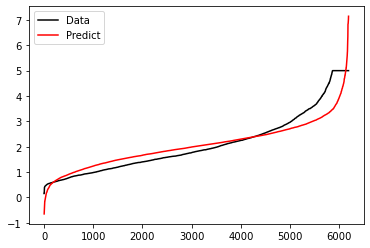

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(Ytest)), sorted(Ytest), c='black', label='Data')
plt.plot(range(len(yhat)), sorted(yhat), c='red', label='Predict')
plt.legend()
plt.show()

可见，虽然我们的大部分数据被拟合得比较好，但是图像的开头和结尾处却又着较大的拟合误差。如果我们在图像右侧分布着更多的数据，我们的模型就会越来越偏离我们真正的标签。这种结果类似于我们前面提到的，虽然在有限的数据集上将数值预测正确了，但却没有正确拟合数据的分布，如果有更多的数据进入我们的模型，那数据标签被预测错误的可能性是非常大的。

# 4 改善多重共线性的算法：岭回归与Lasso
在线性模型之中，除了线性回归之外，最知名的就是岭回归与Lasso了。这两个算法非常神秘，他们的原理和应用都不像其他算法那样高调，学习资料也很少。这可能是因为这两个算法不是为了提升模型表现，而是为了修复多重共线性而设计的（**实际上，使用岭回归或者Lasso，模型的效果往往会下降一些，因为我们删除了一小部分信息**），因此在结果为上的机器学习领域颇有些被冷落的意味。
## 4.1 岭回归
# 截图
### 4.2.2 linear_model.Ridge
在sklearn中，岭回归由线性模型库中的Ridge类来调用：
*class sklearn.linear_model.Ridge(alpha=1.0,fit_intercept=True,normalize=False,copy_X=True,max_iter=None,tol=0.001,solver=’auto’,random_state=None)*

和线性回归相比，岭回归核心的参数就是**正则项的系数$\alpha$**，其他的参数是当我们希望使用最小二乘法之外的求解方法求解岭回归的时候才需要的，通常我们完全不会去触碰这些参数。

前面在加利福尼亚房屋价值数据集上使用线性回归，得出的结果大概是训练集上的拟合程度是60%，测试集上的拟合程度也是60%左右，那这个很低的拟合程度是不是由多重共线性造成的呢？在统计学中，会通过VIF或者各种检验来判断数据是否存在共线性，然而在机器学习中，可以使用模型来判断：**如果一个数据集在岭回归中使用各种正则化参数取值下模型表现没有明显上升（比如出现持平或者下降），则说明数据没有多重共线性，顶多是特征之间有一些相关性。反之，如果一个数据集在岭回归的各种正则化参数取值下表现出明显的上升趋势，则说明数据存在多重共线性**。

接下来，在加利福尼亚房屋价值数据集上来验证一下这个说法：

In [54]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing as fch  # 加利福尼亚房屋价值数据集
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target
X.columns = ["住户收入中位数", "房屋使用年代中位数", "平均房间数目", "平均卧室数目", "街区人口", "平均入住率", "街区的纬度", "街区的经度"]
X.head()

,住户收入中位数,房屋使用年代中位数,平均房间数目,平均卧室数目,街区人口,平均入住率,街区的纬度,街区的经度
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


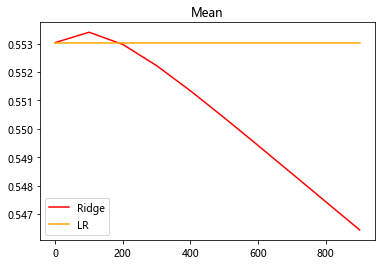

In [57]:
# 数据集划分
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)
for i in [Xtrain, Xtest]:  # 重置索引，以免后续索引出错
    i.index = range(i.shape[0])

# 岭回归
reg = Ridge(alpha=1).fit(Xtrain, Ytrain)
reg.score(Xtest, Ytest)  # 0.60436，跟线性回归的结果差不多，初步判断不存在多重共线性

# 交叉验证下，正则化参数alpha的学习曲线
alpharange = np.arange(1, 1001, 100)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg, X, y, cv=5, scoring="r2").mean()
    linears = cross_val_score(linear, X, y, cv=5, scoring="r2").mean()
    ridge.append(regs)
    lr.append(linears)
plt.plot(alpharange, ridge, color="red", label="Ridge")
plt.plot(alpharange, lr, color="orange", label="LR")
plt.title("Mean")
plt.legend()
plt.show()

可以看到在前段，岭回归的结果有一点上升，可以认为数据有多重共线性，但是这个多重共线性的程度并不严重，因为岭回归的拟合程度只上升了很小。这也说明了，**岭回归的主要作用是修复多重共线性，而不是提升模型的拟合程度**。

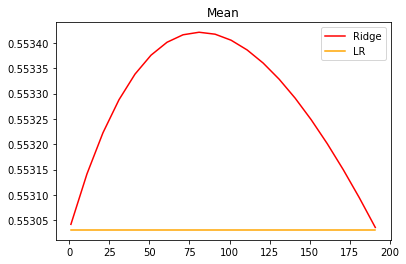

In [13]:
# 细化学习曲线
alpharange = np.arange(1, 201, 10)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg, X, y, cv=5, scoring="r2").mean()
    linears = cross_val_score(linear, X, y, cv=5, scoring="r2").mean()
    ridge.append(regs)
    lr.append(linears)

plt.plot(alpharange, ridge, color="red", label="Ridge")
plt.plot(alpharange, lr, color="orange", label="LR")
plt.title("Mean")
plt.legend()
plt.show()

可以看出，加利佛尼亚数据集上，岭回归的结果轻微上升，随后骤降。可以说，加利佛尼亚房屋价值数据集带有很轻微的一部分共线性，这种共线性被正则化参数消除后，模型的效果提升了一点点，但是对于整个模型而言是杯水车薪。在过了控制多重共线性的点后，模型的效果飞速下降，显然是正则化的程度太重，挤占了参数本来的估计空间。

从这个结果可以看出，加利佛尼亚数据集的核心问题不在于多重共线性，岭回归不能够提升模型表现。另外，在正则化参数逐渐增大的过程中，我们可以观察一下模型的方差如何变化：

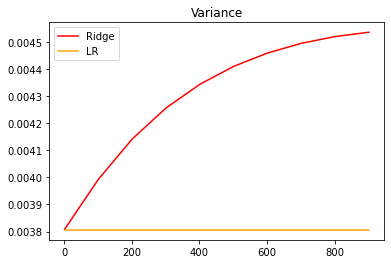

In [17]:
#模型方差如何变化？
alpharange = np.arange(1, 1001, 100)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg, X, y, cv=5, scoring="r2").var()
    linears = cross_val_score(linear, X, y, cv=5, scoring="r2").var()
    ridge.append(regs)
    lr.append(linears)
plt.plot(alpharange, ridge, color="red", label="Ridge")
plt.plot(alpharange, lr, color="orange", label="LR")
plt.title("Variance")
plt.legend()
plt.show()

可以发现，模型的方差上升快速，不过方差的值本身很小，其变化不超过上升部分的1/3，因此只要噪声的状况维持恒定，模型的泛化误差可能还是一定程度上降低了的。**虽然岭回归和Lasso不是设计来提升模型表现，而是专注于解决多重共线性问题的，但当在一定范围内变动的时候，消除多重共线性也许能够一定程度上提高模型的泛化能力**。但是泛化能力毕竟没有直接衡量的指标，因此我们往往只能够通过观察模型的准确性指标和方差来大致评判模型的泛化能力是否提高。

来看看多重共线性更为明显一些的情况：

D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func

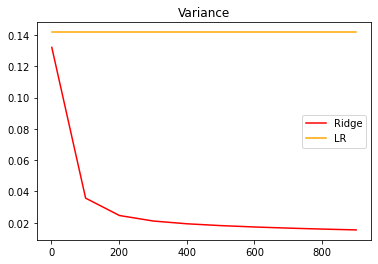

In [22]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score

X = load_boston().data
y = load_boston().target
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)

#先查看方差的变化
alpharange = np.arange(1, 1001, 100)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg, X, y, cv=5, scoring="r2").var()
    linears = cross_val_score(linear, X, y, cv=5, scoring="r2").var()
    ridge.append(regs)
    lr.append(linears)
plt.plot(alpharange, ridge, color="red", label="Ridge")
plt.plot(alpharange, lr, color="orange", label="LR")
plt.title("Variance")
plt.legend()
plt.show()


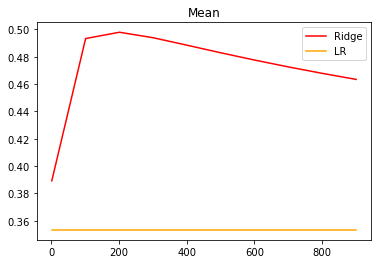

In [23]:
#查看R2的变化
alpharange = np.arange(1, 1001, 100)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg, X, y, cv=5, scoring="r2").mean()
    linears = cross_val_score(linear, X, y, cv=5, scoring="r2").mean()
    ridge.append(regs)
    lr.append(linears)
plt.plot(alpharange, ridge, color="red", label="Ridge")
plt.plot(alpharange, lr, color="orange", label="LR")
plt.title("Mean")
plt.legend()
plt.show()


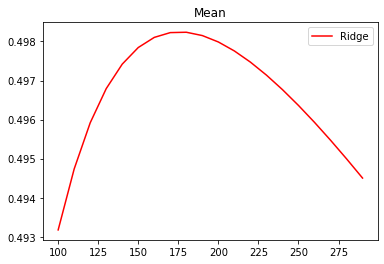

In [24]:
# 细化学习曲线
alpharange = np.arange(100, 300, 10)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg, X, y, cv=5, scoring="r2").mean()
    # linears = cross_val_score(linear, X, y, cv=5, scoring="r2").mean()
    ridge.append(regs)
    # lr.append(linears)
plt.plot(alpharange, ridge, color="red", label="Ridge")
# plt.plot(alpharange, lr, color="orange", label="LR")
plt.title("Mean")
plt.legend()
plt.show()

可以发现，比起加利佛尼亚房屋价值数据集，波士顿房价数据集的方差降低明显，$R^2$也上升，可见使用岭回归还是起到了一定的作用，模型的泛化能力是有可能会上升的。
我们也许找一些高相关性的数据，但是如果去尝试就会发现，基本上如果我们使用岭回归或者Lasso，那模型的效果都是会降低的，很难升高，这恐怕也是岭回归和Lasso一定程度上被机器学习领域冷遇的原因。
### 4.2.3 选取最佳的正则化参数$\alpha$
在各种机器学习教材中，总是教导使用岭迹图来判断正则项参数的最佳取值。传统的岭迹图长这样，形似一个开口的喇叭图（根据横坐标的正负，喇叭有可能朝右或者朝左）：
# 截图
这一个以正则化参数为横坐标，线性模型求解的系数为纵坐标的图像，其中每一条彩色的线都是一个系数。其目标是建立正则化参数与系数之间的直接关系，以此来观察正则化参数的变化如何影响了系数的拟合。**岭迹图认为，线条交叉越多，则说明特征之间的多重共线性越高。我们应该选择系数较为平稳的喇叭口所对应的取值作为最佳的正则化参数的取值**。绘制岭迹图的方法非常简单，代码如下：

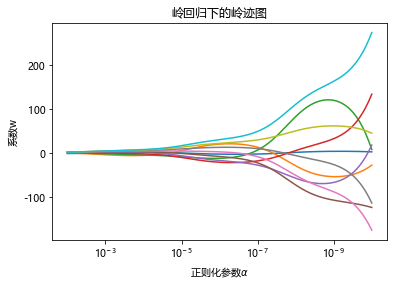

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体：解决plot不能显示中文问题
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 创造10*10的希尔伯特矩阵
X = 1.0 / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

# 计算横坐标
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)  # 在对alpha取对数后，其值在-10到-2之间均匀分布

# 建模，获取每一个正则化取值下的系数组合
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# 绘图
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')  # 对横坐标取对数
ax.set_xlim(ax.get_xlim()[::-1])  # 反转横坐标,让正则化参数从大到小显示
plt.xlabel('正则化参数$\\alpha$')
plt.ylabel('系数w')
plt.title('岭回归下的岭迹图')
plt.axis('tight')  # 自动调整坐标轴范围
plt.show()

然而，非常不建议使用岭迹图来作为寻找最佳参数的标准。有这样的两个理由：
1. 岭迹图的很多细节，很难以解释。比如为什么多重共线性存在会使得线与线之间有很多交点？当很大了之后看上去所有的系数都很接近于0，难道不是那时候线之间的交点最多吗？
2. 岭迹图的评判标准，非常模糊。哪里才是最佳的喇叭口？哪里才是所谓的系数开始变得”平稳“的时候？一千个读者一千个哈姆雷特的画像？未免也太不严谨了。

岭迹图只是教学中会被略微提到的一个知识点（还会被强调是过时的技术），在现实中，真正**用来选择正则化系数的技术是交叉验证**，并且选择的标准非常明确——我们选择让交叉验证下的均方误差最小的正则化系数。在sklearn中，我们有带交叉验证的岭回归可以使用：
*class sklearn.linear_model.RidgeCV (alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=False)*
可以看到，这个类于普通的岭回归类Ridge非常相似，不过在输入正则化系数$\alpha$的时候可以传入元祖作为正则化系数的备选，非常类似于在画学习曲线前设定的for i in 的列表对象。来看RidgeCV的重要参数，属性和接口：
# 截图
这个类的使用也非常容易，依然使用我们之前建立的加利佛尼亚房屋价值数据集：


In [64]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.datasets import fetch_california_housing as fch  # 加利佛尼亚房屋价值数据集

housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target
X.columns = ["住户收入中位数", "房屋使用年代中位数", "平均房间数目", "平均卧室数目",
             "街区人口", "平均入住率", "街区的纬度", "街区的经度"]

Ridge_ = RidgeCV(alphas=np.arange(1, 11, 1)  #设定搜索的参数范围，内置寻找最佳正则化系数
                 # , scoring='neg_mean_squared_error'  # 默认以R方作为模型评估指标，这里也可以自定义评估指标
                 , store_cv_values=True  # 保存每次交叉验证的结果值，默认为False
                 # ,cv=5 # 默认为None，使用默认的留一交叉验证
                 ).fit(X, y)
# 无关交叉验证的岭回归
print(Ridge_.score(X, y))
# 调用所有交叉验证的结果
print(Ridge_.cv_values_.shape)
# 进行平均后可以查看每个正则化系数取值下的交叉验证结果
print(Ridge_.cv_values_.mean(axis=0))  # axis=0表示按列求均值,均方误差mse
# 查看被选择出来的最佳正则化系数
print(Ridge_.alpha_)

0.6062301017653543
(20640, 10)
[0.52823795 0.52822981 0.52822179 0.52821388 0.52820609 0.52819841
 0.52819084 0.52818338 0.52817604 0.5281688 ]
10


## 4.3 Lasso回归
### 4.3.2 Lasso的核心作用：特征选择
*class sklearn.linear_model.Lasso (alpha=1.0, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection=’cyclic’)*
sklearn中我们使用类Lasso来调用lasso回归，众多参数中我们需要比较在意的就是参数$\alpha$，正则化系数。另外需要注意的就是参数positive。当这个参数为"True"的时候，是要求Lasso回归出的系数必须为正数，以此来保证我们的$\alpha$一定以增大来控制正则化的程度

接下来来看看lasso如何做特征选择：

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing as fch  # 加利佛尼亚房屋价值数据集
import matplotlib.pyplot as plt

housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target
X.columns = ["住户收入中位数", "房屋使用年代中位数", "平均房间数目", "平均卧室数目",
             "街区人口", "平均入住率", "街区的纬度", "街区的经度"]
X.head()

,住户收入中位数,房屋使用年代中位数,平均房间数目,平均卧室数目,街区人口,平均入住率,街区的纬度,街区的经度
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)

# 恢复索引
for i in [Xtrain, Xtest]:
    i.index = range(i.shape[0])

In [7]:
# 线性回归
reg = LinearRegression().fit(Xtrain, Ytrain)
(reg.coef_ * 100).tolist()

[43.735893059684,
 1.0211268294493883,
 -10.780721617317667,
 62.64338275363759,
 5.216125353348089e-05,
 -0.3348509646333704,
 -41.30959378947717,
 -42.62109536208464]

In [11]:
# 岭回归
Ridge_ = Ridge(alpha=0.01).fit(Xtrain, Ytrain)  # alpha=0表示无约束，即普通的线性回归
(Ridge_.coef_ * 100).tolist()

[43.73575720621552,
 1.0211292318121366,
 -10.780460336250988,
 62.64202320775456,
 5.2170680732269345e-05,
 -0.33485065170675665,
 -41.30957143229447,
 -42.62105388932737]

In [12]:
# Lasso回归
lasso_ = Lasso(alpha=0.01).fit(Xtrain, Ytrain)
(lasso_.coef_ * 100).tolist()

[40.10568371834484,
 1.0936292607860145,
 -3.742376361024448,
 26.524037834897175,
 0.00035253685115039455,
 -0.32071293948877994,
 -40.064830473448424,
 -40.81754399163315]

加大正则化系数，观察模型的系数发生了什么变化

In [14]:
# 岭回归
Ridge_ = Ridge(alpha=10 ** 4).fit(Xtrain, Ytrain)
(Ridge_.coef_ * 100).tolist()  # 有几个系数几乎为0了

[34.62081517607707,
 1.519617086923876,
 0.3968610529210008,
 0.9151812510355452,
 0.0021739238012248546,
 -0.34768660148101116,
 -14.736963474215475,
 -13.43557610252718]

In [15]:
# Lasso回归
lasso_ = Lasso(alpha=10 ** 4).fit(Xtrain, Ytrain)
(lasso_.coef_ * 100).tolist()  # 全为0

[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0]

看来10**4对于lasso回归来说，已经是一个非常大的正则化系数了.

In [20]:
lasso_ = Lasso(alpha=1).fit(Xtrain, Ytrain)
(lasso_.coef_ * 100).tolist()  # 体现了Lasso回归的特性，自动进行特征选择

[14.581141247629423,
 0.6209347344423876,
 0.0,
 -0.0,
 -0.0002806598632901,
 -0.0,
 -0.0,
 -0.0]

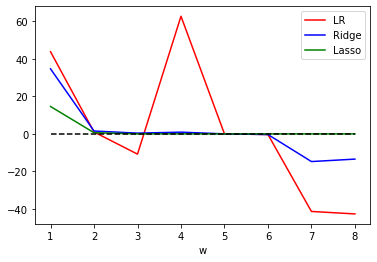

In [21]:
# 将系数进行绘图
plt.plot(range(1, 9), (reg.coef_ * 100).tolist(), c='r', label="LR")
plt.plot(range(1, 9), (Ridge_.coef_ * 100).tolist(), c='b', label="Ridge")
plt.plot(range(1, 9), (lasso_.coef_ * 100).tolist(), c='g', label="Lasso")
plt.plot(range(1, 9), [0] * 8, c='black', linestyle="--")
plt.xlabel("w")
plt.legend()
plt.show()

可见，比起岭回归，Lasso所带的L1正则项对于系数的惩罚要重得多，并且它会将系数压缩至0，因此可以被用来做特征选择。也因此，我们往往让Lasso的正则化系数在很小的空间中变动，以此来寻找最佳的正则化系数。
### 4.3.3 选取最佳的正则化参数取值
`class sklearn.linear_model.LassoCV (eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute=’auto’, max_iter=1000, tol=0.0001, copy_X=True, cv=’warn’, verbose=False, n_jobs=None, positive=False, random_state=None, selection=’cyclic’)`


In [29]:
from sklearn.linear_model import LassoCV

# 建立alphas取值范围
alpharange = np.logspace(-10, -2, 200, base=10)  # 以10为底对数

lasso_ = LassoCV(alphas=alpharange  # 自行输入的alphas取值范围
                 , cv=5  # 交叉验证的折数
                 ).fit(Xtrain, Ytrain)

# 查看被选择出来的最佳正则化系数
print(lasso_.alpha_)
# 调用所有的交叉验证结果
print(lasso_.mse_path_.shape)  # 返回每个alpha下交叉验证的结果，共有200个alpha，5折交叉验证，所以返回结果是200*5的矩阵
print(lasso_.mse_path_.mean(axis=1))  # 对每一行求均值，得到每个alpha取值下的交叉验证结果
# 最佳正则化系数下的模型系数
print(lasso_.coef_)
# 得分
print(lasso_.score(Xtest, Ytest))

# 与线性回归相比如何？
print(LinearRegression().fit(Xtrain, Ytrain).score(Xtest, Ytest))  # 略胜一筹

0.0020729217795953697
(200, 5)
[0.52816924 0.52742297 0.5268146  0.52632488 0.52593241 0.52561942
 0.52537133 0.5251761  0.52502385 0.52490641 0.52481712 0.52475046
 0.52470198 0.52466795 0.52464541 0.52463188 0.5246254  0.52462436
 0.52462744 0.52463361 0.52464201 0.52465199 0.52466301 0.52467466
 0.5246866  0.5246986  0.52471046 0.52472203 0.5247332  0.52474392
 0.52475413 0.52476379 0.52477291 0.52478147 0.52478949 0.52479697
 0.52480393 0.52481039 0.52481639 0.52482193 0.52482706 0.52483179
 0.52483615 0.52484016 0.52484385 0.52484725 0.52485036 0.52485322
 0.52485584 0.52485824 0.52486044 0.52486246 0.5248643  0.52486599
 0.52486753 0.52486895 0.52487024 0.52487141 0.52487249 0.52487348
 0.52487437 0.52487519 0.52487594 0.52487663 0.52487725 0.52487782
 0.52487834 0.52487882 0.52487925 0.52487965 0.52488001 0.52488033
 0.52488063 0.52488091 0.52488116 0.52488138 0.52488159 0.52488178
 0.52488195 0.52488211 0.52488225 0.52488239 0.5248825  0.52488261
 0.52488271 0.5248828  0.524882

使用LassoCV自带的正则化路径长度和路径中的正则化系数个数来自动建立alphas取值范围：

In [36]:
ls_ = LassoCV(eps=0.00001, n_alphas=300, cv=5).fit(Xtrain, Ytrain)
print(ls_.alpha_)
print(ls_.alphas_.shape)  # 查看自动建立的alphas取值
print(ls_.score(Xtest, Ytest))  # 不咋样
print(ls_.coef_)

0.0020954551690628557
(300,)
0.60389154238192
[ 4.29785372e-01  1.03639989e-02 -9.31060823e-02  5.50940621e-01
  1.15407943e-06 -3.31909776e-03 -4.10423420e-01 -4.22369926e-01]


除了解决多重共线性这个核心问题之外，**线性模型还有更重要的事情要做：提升模型表现**。这才是机器学习最核心的需求，而Lasso和岭回归不是为此而设计的。下一节，让我们来认识一下为了提升模型表现而做出的改进：多项式回归。

# 5 非线性问题：多项式回归
对于回归问题，数据分布若为一条直线，则是线性的，否则是非线性。对于分类问题，数据分布若能使用一条直线来划分类别，则是线性可分的，否则数据则是线性不可分的。
### 5.1.3 线性模型与非线性模型
线性回归在非线性数据上的表现如何呢？我们来建立一个明显是非线性的数据集，并观察线性回归和决策树回归在拟合非线性数据集时的表现：

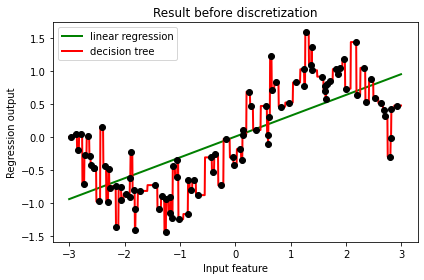

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# 生成非线性数据
rnd = np.random.RandomState(42)  # 设置随机数种子
X = rnd.uniform(-3, 3, size=100)  # random.uniform从输入的任意两个整数中取出size个随机数
y = np.sin(X) + rnd.normal(size=len(X)) / 3  # random.normal生成size个服从正态分布的随机数

# 观察数据集
# plt.scatter(X, y, marker='o', c='k', s=20)
# plt.show()

# 为后续建模做准备：sklearn只接受二维以上数组作为特征矩阵的输入
X = X.reshape(-1, 1)

# 使用数据进行建模
LinearR = LinearRegression().fit(X, y)
TreeR = DecisionTreeRegressor(random_state=0).fit(X, y)

# 放置画布
fig, ax1 = plt.subplots(1)

# 创建测试数据：一系列分布在横坐标上的点
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

# 将测试数据带入predict接口，获得模型的拟合效果并进行绘制
ax1.plot(line, LinearR.predict(line), linewidth=2, color='green', label="linear regression")
ax1.plot(line, TreeR.predict(line), linewidth=2, color='red', label="decision tree")

# 将原数据上的拟合绘制在图像上
ax1.plot(X[:, 0], y, 'o', c='k')

ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")
plt.tight_layout()
plt.show()

从图像上可以看出，线性回归无法拟合出这条带噪音的正弦曲线的真实面貌，只能够模拟出大概的趋势，而决策树却通过建立复杂的模型将几乎每个点都拟合出来了。可见，使用线性回归模型来拟合非线性数据的效果并不好，而决策树这样的模型却拟合得太细致，但是相比之下，还是决策树的拟合效果更好一些。

模型在线性和非线性数据集上的表现为我们选择模型提供了一个思路：**当我们获取数据时，我们往往希望使用线性模型来对数据进行最初的拟合（线性回归用于回归，逻辑回归用于分类），如果线性模型表现良好，则说明数据本身很可能是线性的或者线性可分的，如果线性模型表现糟糕，那毫无疑问我们会投入决策树，随机森林这些模型的怀抱，就不必浪费时间在线性模型上了**。

不过这并不代表着我们就完全不能使用线性模型来处理非线性数据了。在现实中，线性模型有着不可替代的优势：计算速度异常快速，所以也还是存在着我们无论如何也希望使用线性回归的情况。因此，我们有多种手段来处理线性回归无法拟合非线性问题的问题。

## 5.2 使用分箱处理非线性问题
让线性回归在非线性数据上表现提升的核心方法之一是**对数据进行分箱，也就是离散化**。与线性回归相比，我们常用的一种回归是决策树的回归。前文拟合过一条带有噪音的正弦曲线以展示多元线性回归与决策树的效用差异，在此基础上，我们采取相关措施帮助我们的线性回归。为了让线性回归在类似的数据上变得更加强大，我们可以使用分箱，也就是离散化连续型变量的方法来处理原始数据，以此来提升线性回归的表现。来看看我们如何实现：

In [4]:
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# 生成非线性数据
rnd = np.random.RandomState(42)  # 设置随机数种子
X = rnd.uniform(-3, 3, size=100)  # random.uniform从输入的任意两个整数中取出size个随机数
y = np.sin(X) + rnd.normal(size=len(X)) / 3  # random.normal生成size个服从正态分布的随机数
# 为后续建模做准备：sklearn只接受二维以上数组作为特征矩阵的输入
X = X.reshape(-1, 1)

# 将数据分箱
enc = KBinsDiscretizer(n_bins=10, encode='onehot')  # 将数据分为10箱
X_binned = enc.fit_transform(X)  # (100,10)
# encode模式"onehot"：使用做哑变量方式做离散化
# 之后返回一个稀疏矩阵(m,n_bins)，每一列是一个分好的类别
# 对每一个样本而言，它包含的分类（箱子）中它表示为1，其余分类中它表示为0

# 使用pandas查看分箱后的数据
pd.DataFrame(X_binned.toarray()).head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


分箱前后的线性模型的R^2: 0.6800102369793312 0.944133075051055
分箱前后的决策树模型的R^2: 0.8478082863491422 0.944133075051055


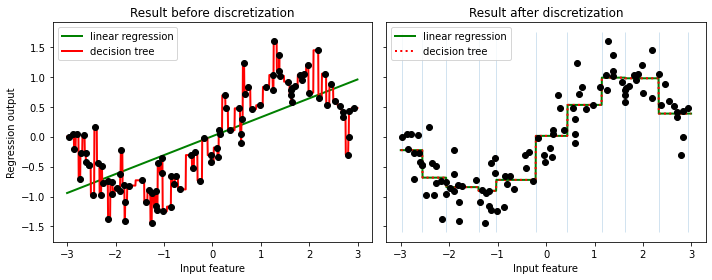

In [5]:
# 建模
LinearR = LinearRegression().fit(X, y)
LinearR_ = LinearRegression().fit(X_binned, y)
TreeR = DecisionTreeRegressor(random_state=0).fit(X, y)
TreeR_ = DecisionTreeRegressor(random_state=0).fit(X_binned, y)
# 创建测试数据：一系列分布在横坐标上的点
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
line_binned = enc.transform(line)  # 将测试数据分箱
# LinearR_.predict(line_binned).shape # (1000,)

# 绘图
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))  # sharey=True表示两个子图共用一个y轴
# 在图1中布置在原数据上建模的结果
ax1.plot(line, LinearR.predict(line), linewidth=2, color='green', label="linear regression")
ax1.plot(line, TreeR.predict(line), linewidth=2, color='red', label="decision tree")
ax1.plot(X[:, 0], y, 'o', c='k')
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")

# 进行预测
ax2.plot(line, LinearR_.predict(line_binned), linewidth=2, color='green', linestyle='-', label='linear regression')
ax2.plot(line, TreeR_.predict(line_binned), linewidth=2, color='red', linestyle=':', label='decision tree')
print('分箱前后的线性模型的R^2:', LinearR.score(line, np.sin(line)), LinearR_.score(line_binned, np.sin(line)))
print('分箱前后的决策树模型的R^2:', TreeR.score(line, np.sin(line)), TreeR_.score(line_binned, np.sin(line)))

# 绘制和箱宽一致的竖线
ax2.vlines(enc.bin_edges_[0]  # x轴坐标
           , *plt.gca().get_ylim()  # y轴的上限和下限
           , linewidth=1, alpha=.2)

# 将原始数据分布放置在在图像上
ax2.plot(X[:, 0], y, 'o', c='k')

# 设置其他参数
ax2.legend(loc="best")
ax2.set_xlabel("Input feature")
ax2.set_title("Result after discretization")
plt.tight_layout()
plt.show()

从图像上可以看出，离散化后线性回归和决策树上的预测结果完全相同了——线性回归比较成功地拟合了数据的分布，而决策树的过拟合效应也减轻了。由于特征矩阵被分箱，因此特征矩阵在每个区域内获得的值是恒定的，因此所有模型对同一个箱中所有的样本都会获得相同的预测值。与分箱前的结果相比，线性回归明显变得更加灵活，而决策树的过拟合问题也得到了改善。但注意，一般来说我们是不使用分箱来改善决策树的过拟合问题的，因为树模型带有丰富而有效的剪枝功能来防止过拟合。

在这个例子中，我们设置的分箱箱数为10，不难想到这个箱数的设定肯定会影响模型最后的预测结果，我们来看看如何选取最佳的箱子数：

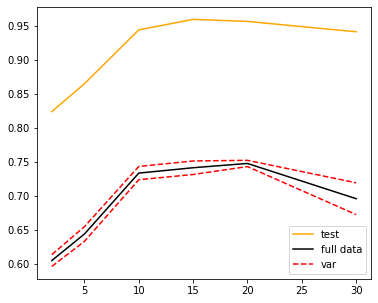

In [6]:
from sklearn.model_selection import cross_val_score as CVS

pred, score, var = [], [], []
binsrange = [2, 5, 10, 15, 20, 30]  # 设置不同的分箱数
for i in binsrange:
    enc = KBinsDiscretizer(n_bins=i, encode='onehot')
    X_binned = enc.fit_transform(X)
    line_binned = enc.transform(line)
    # 建立模型
    LinearR_ = LinearRegression()
    # 进行交叉验证
    cvresult = CVS(LinearR_, X_binned, y, cv=5)
    score.append(cvresult.mean())
    var.append(cvresult.var())
    # 测试数据集上的打分结果
    pred.append(LinearR_.fit(X_binned, y).score(line_binned, np.sin(line)))
# 绘制图像
plt.figure(figsize=(6, 5))
plt.plot(binsrange, pred, c='orange', label='test')
plt.plot(binsrange, score, c='k', label='full data')
plt.plot(binsrange, score + np.array(var) * 0.5, c='red', linestyle='--', label='var')
plt.plot(binsrange, score - np.array(var) * 0.5, c='red', linestyle='--')
plt.legend()
plt.show()

由图像可以看出，在箱子数为20时模型比较稳定，且在测试集上的表现也不错，因此我们可以选择箱子数为20。
在工业中，大量离散化变量与线性模型连用的实例很多，在深度学习出现之前，这种模式甚至一度统治一些工业中的机器学习应用场景，可见效果优秀，应用广泛。对于现在的很多工业场景而言，大量离散化特征的情况可能已经不是那么多了，不过依然需要对“分箱能够解决线性模型无法处理非线性数据的问题”有所了解。
## 5.3 多项式回归PolynomialFeatures
线性模型中的升维工具：**多项式变化**。这是一种通过增加自变量上的次数，而将数据映射到高维空间的方法，只要我们设定一个自变量上的次数（大于1），就可以相应地获得数据投影在高次方的空间中的结果。这种方法可以非常容易地通过sklearn中的类PolynomialFeatures来实现。我们先来简单看看这个类是如何使用的。
`class sklearn.preprocessing.PolynomialFeatures (degree=2, interaction_only=False, include_bias=True)`
- degree：控制多项式的次数
- interaction_only：默认为False，是否只产生交互项
- include_bias：默认为True，是否包含截距项，即是否产生与截距相乘的$x_0=1$

In [51]:
from sklearn.preprocessing import PolynomialFeatures

X = np.arange(6).reshape(3, 2)

# 二次多项式
X_ = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True).fit_transform(X)
print('普通的二次多项式：\n', X_)
# 只有交互项的二次多项式
X_ = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True).fit_transform(X)
print('只有交互项的二次多项式:\n', X_)
# 不带截距项的二次多项式
X_ = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False).fit_transform(X)
print('不带截距项的二次多项式:\n', X_)

普通的二次多项式：
 [[ 1.  0.  1.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]
只有交互项的二次多项式:
 [[ 1.  0.  1.  0.]
 [ 1.  2.  3.  6.]
 [ 1.  4.  5. 20.]]
不带截距项的二次多项式:
 [[ 0.  1.  0.  0.  1.]
 [ 2.  3.  4.  6.  9.]
 [ 4.  5. 16. 20. 25.]]


如此，多项式变化对于数据会有怎样的影响就一目了然了：随着原特征矩阵的维度和规定的最高次数的上升，数据会变得越来越复杂，维度越来越多，并且这种维度的增加并不能用太简单的数学公式表达出来。接下来，来看看多项式回归的根本作用：处理非线性问题。
### 5.3.2 多项式回归处理非线性问题
前文谈过，多项式回归是通过这种将数据投影到高维的方式来解决非线性问题。来看一看多项式转化对模型造成了什么样的影响：

普通线性回归：train score: 0.5361526059318595 test score: 0.6800102369793312
5次多项式回归：train score: 0.8561679370344799 test score: 0.986890445178796


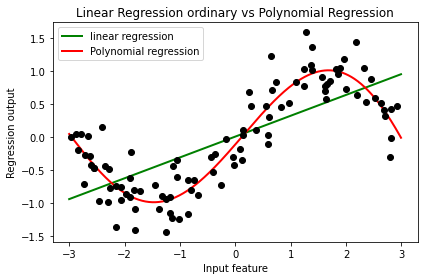

In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

d = 5
rnd = np.random.RandomState(42)
X = rnd.uniform(-3, 3, size=100)
y = (np.sin(X) + rnd.normal(size=len(X)) / 3)
# train data
X = X.reshape(-1, 1)

# 用train data 训练模型
LinearR = LinearRegression().fit(X, y)
poly = PolynomialFeatures(degree=d)
X_ = poly.fit_transform(X)
LinearR_ = LinearRegression().fit(X_, y)

# test data
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
line_ = poly.transform(line)

print('普通线性回归：train score:', LinearR.score(X, y), 'test score:', LinearR.score(line, np.sin(line)))
print(f'{d}次多项式回归：train score:', LinearR_.score(X_, y), 'test score:', LinearR_.score(line_, np.sin(line)))

# 绘图
fig, ax1 = plt.subplots(1)
ax1.plot(line, LinearR.predict(line), linewidth=2, color='green', label="linear regression")
ax1.plot(line, LinearR_.predict(line_), linewidth=2, color='red', label="Polynomial regression")
ax1.plot(X[:, 0], y, 'o', c='k')
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Linear Regression ordinary vs Polynomial Regression")
plt.tight_layout()
plt.show()

从这里可以看出，多项式回归能够较好地拟合非线性数据，还不容易发生过拟合，可以说是保留了线性回归作为线性模型所带的“不容易过拟合”和“计算快速”的性质，同时又实现了优秀地拟合非线性数据。并且多项式回归代码比前面的分箱要简单，效果也好得多，推荐用这种方法。此时可调整的参数即为degree，即多项式的次数。随着次数的增加，模型可以越来越贴近数据，但是也容易出现过拟合的情况。因此，可以使用交叉验证来选择一个合适的degree。

多项式回归非常迷人也非常神奇，因此一直以来都有各种各样围绕着多项式回归进行的讨论。以下是几个常见问题和讨论：

### 5.3.3 多项式回归的可解释性
线性回归是一个具有高解释性的模型，它能够对每个特征拟合出参数以帮助我们理解每个特征对于标签的作用。当进行了多项式转换后，尽管还是形成形如线性回归的方程，但随着数据维度和多项式次数的上升，方程也变得异常复杂，可能无法一眼看出增维后的特征是由之前的什么特征组成的。不过，多项式回归的可解释性依然是存在的，我们可以使用接口get_feature_names_out()来调用生成的新特征矩阵的各个特征上的名称，以便帮助我们解释模型。来看下面的例子：

In [65]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = np.arange(9).reshape(3, 3)
poly = PolynomialFeatures(degree=2).fit(X)
X_ = poly.transform(X)

# 重要接口get_feature_names_out()
print(poly.get_feature_names_out())
print(X_)

['1' 'x0' 'x1' 'x2' 'x0^2' 'x0 x1' 'x0 x2' 'x1^2' 'x1 x2' 'x2^2']
[[ 1.  0.  1.  2.  0.  0.  0.  1.  2.  4.]
 [ 1.  3.  4.  5.  9. 12. 15. 16. 20. 25.]
 [ 1.  6.  7.  8. 36. 42. 48. 49. 56. 64.]]


使用加利佛尼亚房价数据集作为例子，当我们有标签名称的时候，可以直接在接口get_feature_names_out()中输入标签名称来查看新特征究竟是由原特征矩阵中的什么特征组成的：


In [107]:
from sklearn.datasets import fetch_california_housing as fch
import pandas as pd

housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target
X.columns = ["住户收入中位数", "房屋使用年代中位数", "平均房间数目", "平均卧室数目", "街区人口", "平均入住率", "街区的纬度", "街区的经度"]

poly = PolynomialFeatures(degree=2).fit(X)
# poly.get_feature_names_out(X.columns)
X_ = poly.transform(X)

# 建立模型，利用线性回归的coef_属性来看什么特征对标签影响最大
reg = LinearRegression().fit(X_, y)
coef = reg.coef_
# [*zip(poly.get_feature_names_out(X.columns), reg.coef_)]
# 放在DataFrame中进行排序
coeff = pd.DataFrame([poly.get_feature_names_out(X.columns), reg.coef_.tolist()]).T
coeff.columns = ['feature', 'coef']
coeff.sort_values(by='coef')

,feature,coef
4,平均卧室数目,-31.591329
1,住户收入中位数,-11.243025
2,房屋使用年代中位数,-0.848899
33,平均卧室数目 街区的纬度,-0.437043
34,平均卧室数目 街区的经度,-0.404151
12,住户收入中位数 平均卧室数目,-0.186142
15,住户收入中位数 街区的纬度,-0.152506
16,住户收入中位数 街区的经度,-0.144243
32,平均卧室数目 平均入住率,-0.087191
25,平均房间数目 平均卧室数目,-0.068906


可以发现，不仅数据的可解释性还存在，我们还可以通过这样的手段做特征工程——特征创造。多项式帮助我们进行了一系列特征之间相乘的组合，若能够找出组合起来后对标签贡献巨大的特征，那我们就是创造了新的有效特征，对于任何学科而言发现新特征都是非常有价值的。在加利佛尼亚房屋价值数据集上来再次确认多项式回归提升模型表现的能力：

In [112]:
from time import time
from sklearn.ensemble import RandomForestRegressor as RFR

# 查看多项式变化后模型的效果如何？
poly = PolynomialFeatures(degree=3).fit(X)
X_ = poly.transform(X)

reg = LinearRegression().fit(X, y)
print('一次项线性回归：', reg.score(X, y))

time0 = time()
reg_ = LinearRegression().fit(X_, y)
print("三次项线性回归：", reg_.score(X_, y), "time:", time() - time0)

# 使用随机森林呢？
time0 = time()
print("随机森林回归：", RFR(n_estimators=100).fit(X, y).score(X, y), "time:", time() - time0)

一次项线性回归： 0.606232685199805
三次项线性回归： 0.7358642517529423 time: 0.2351984977722168
随机森林回归： 0.974230456255745 time: 10.907731533050537


可以发现，使用随机森林这类非线性模型比多项式回归效果要好得多(悲~)，但是多项式回归的计算速度要快得多，因此在数据量较大的时候，多项式回归还是有其优势的。另外，多项式回归的可解释性也是非常有价值的，因此在特征工程中，多项式回归也是一个非常重要的工具。
